In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import randint as sp_randint



In [ ]:
# Load the dataset
august_data = pd.read_csv('/content/drive/MyDrive/apart/apartments_pl_2023_08.csv')
september_data = pd.read_csv('/content/drive/MyDrive/apart/apartments_pl_2023_09.csv')
october_data = pd.read_csv('/content/drive/MyDrive/apart/apartments_pl_2023_10.csv')
november_data = pd.read_csv('/content/drive/MyDrive/apart/apartments_pl_2023_11.csv')

combined_data = pd.concat([august_data, september_data, october_data, november_data])


In [ ]:
# Define the features and target variable for the regression task
features = [
    'collegeDistance', 'clinicDistance', 'postOfficeDistance',
    'kindergartenDistance', 'restaurantDistance', 'pharmacyDistance'
]
target = 'squareMeters'


*Data visualisation*

Missing values in each feature:
 collegeDistance         2021
clinicDistance           319
postOfficeDistance        95
kindergartenDistance      68
restaurantDistance       193
pharmacyDistance         107
squareMeters               0
dtype: int64
Dropped 24167 duplicate rows


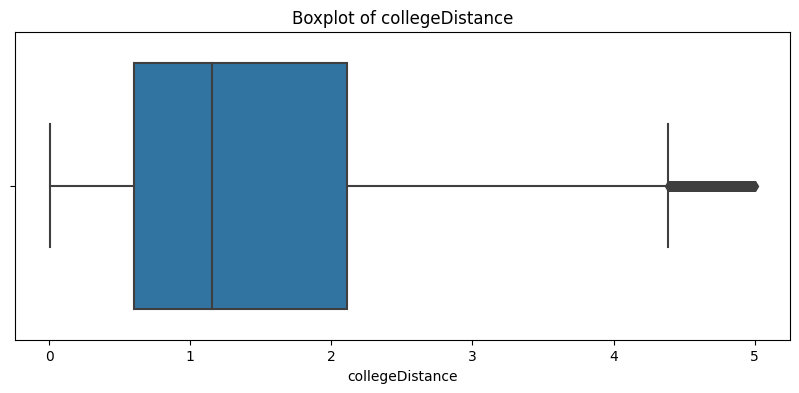

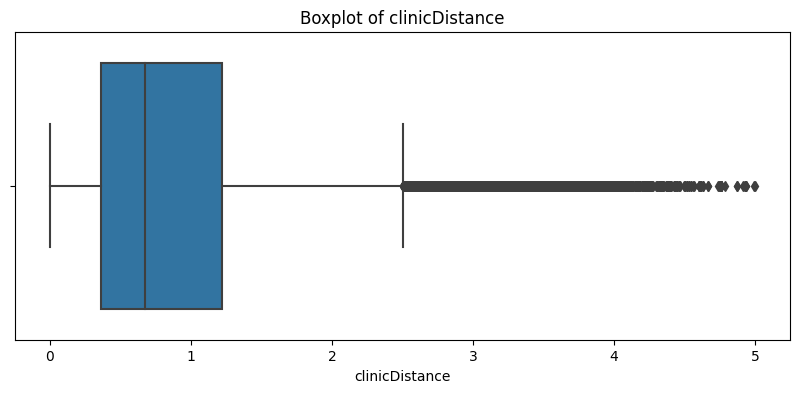

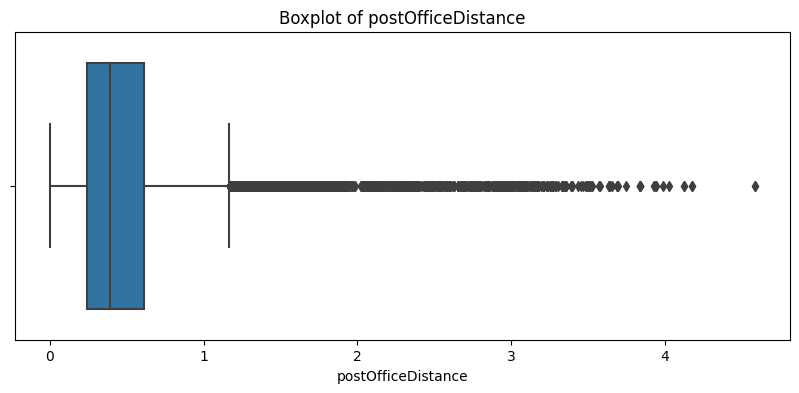

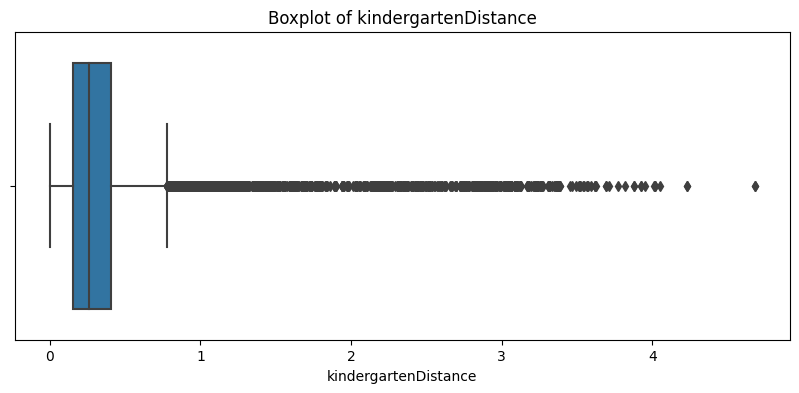

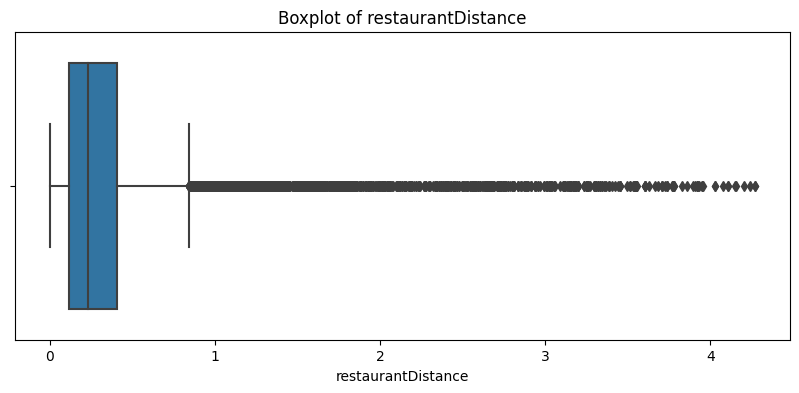

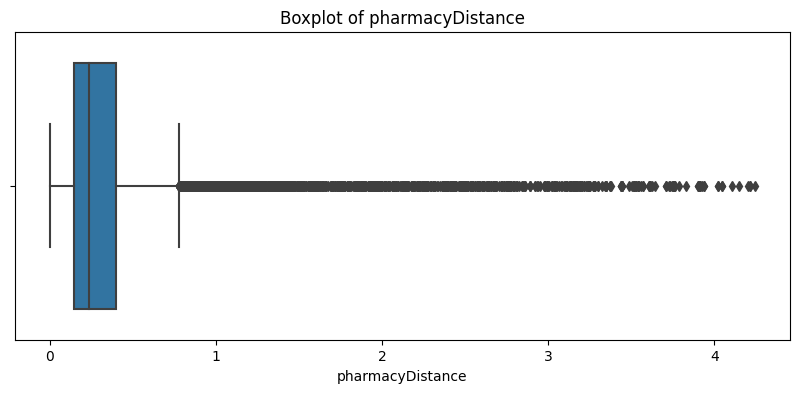

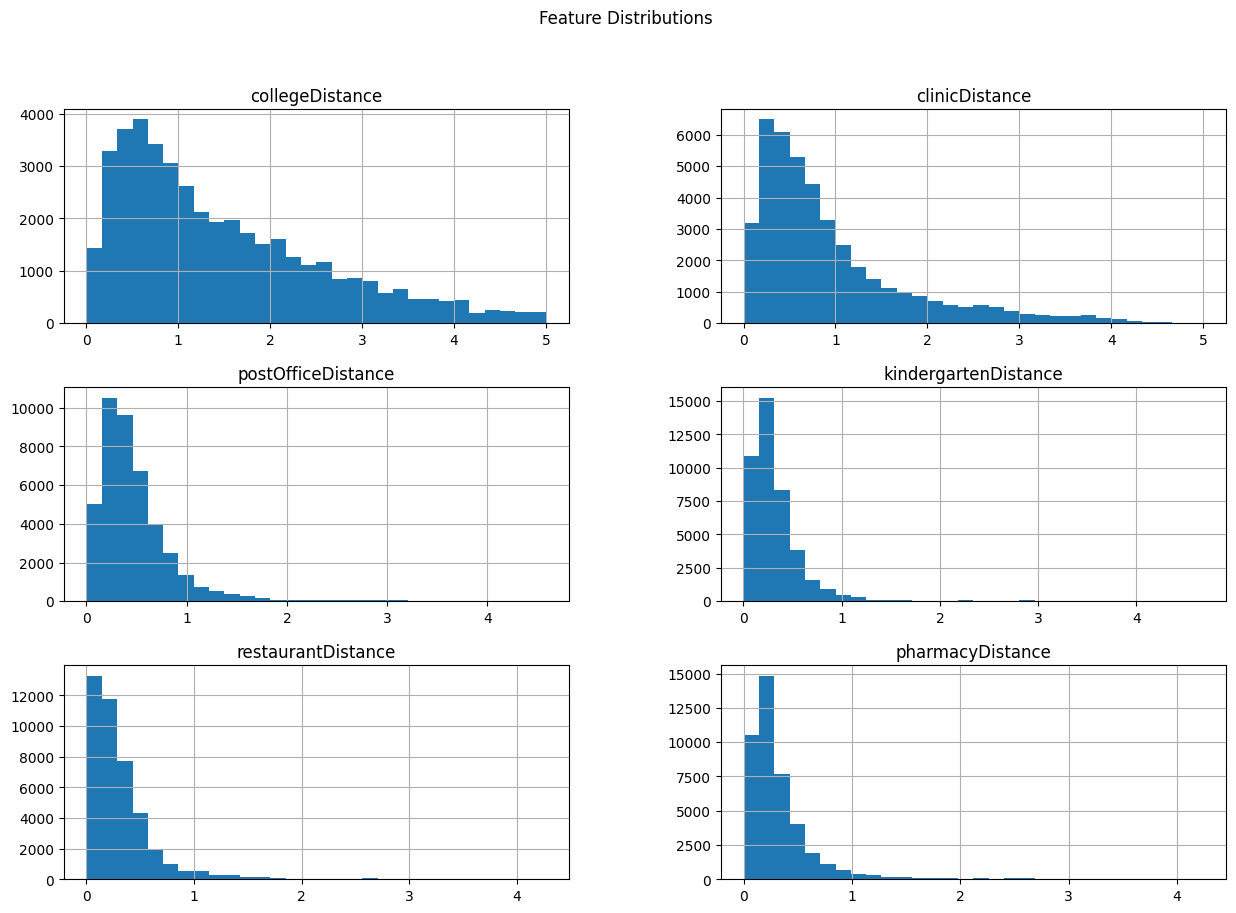

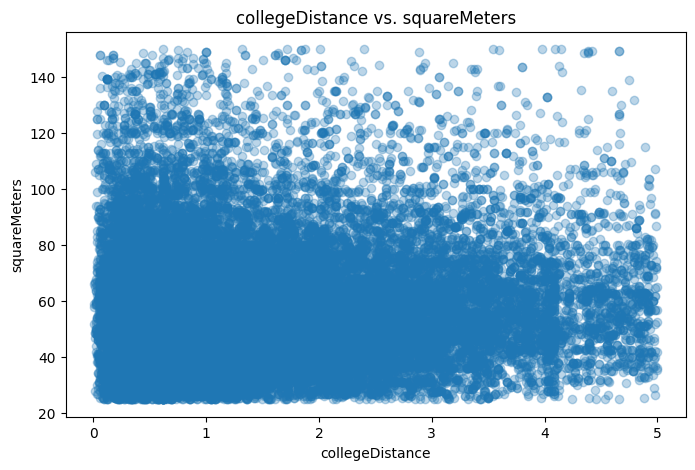

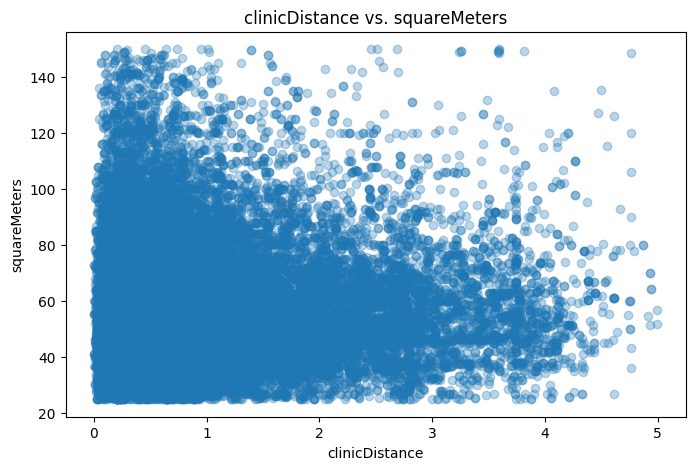

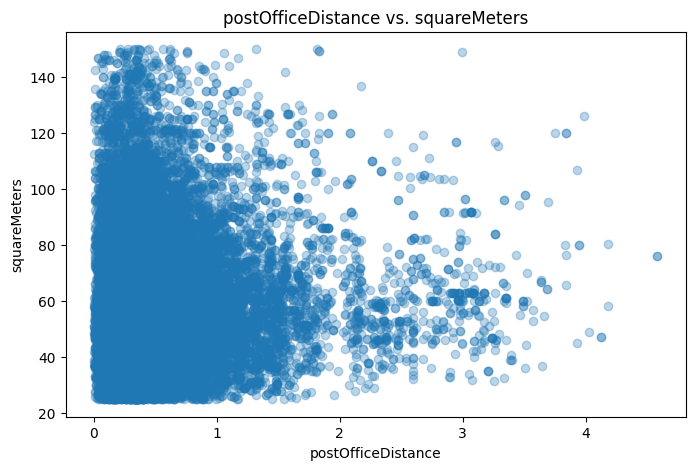

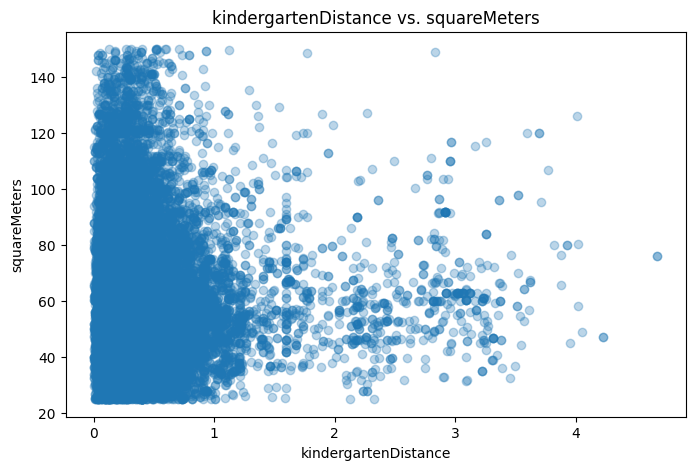

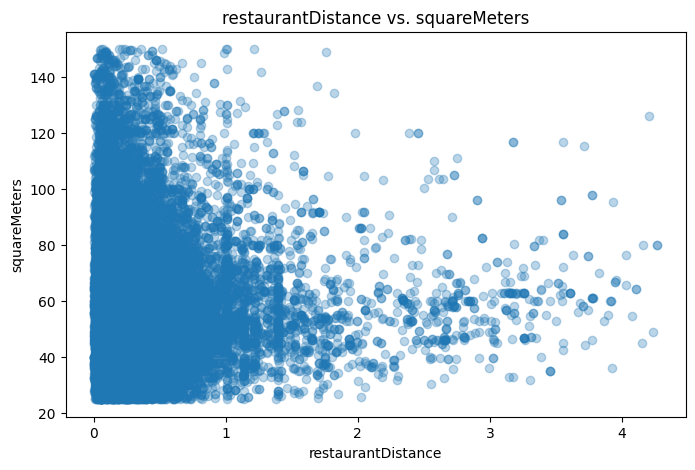

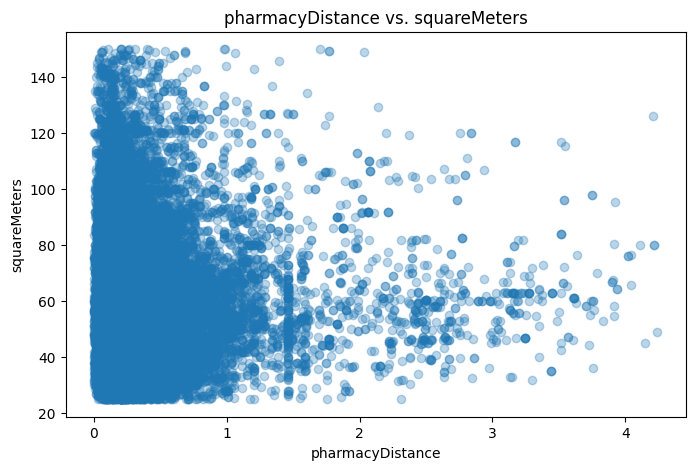

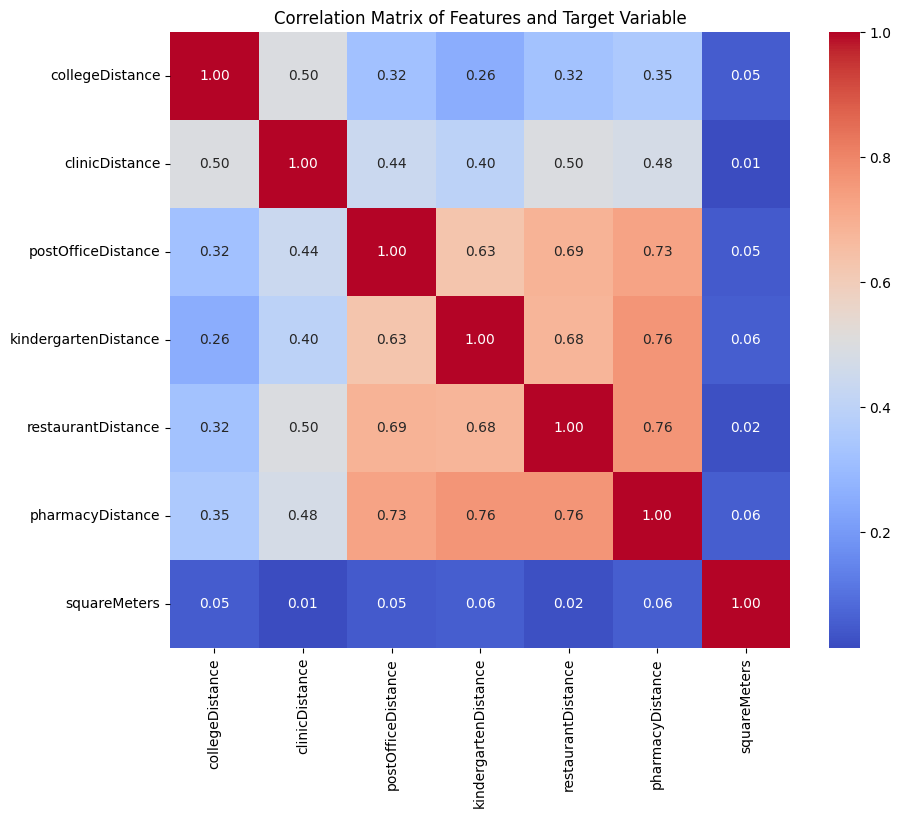

In [ ]:
# Check the number of missing values in each feature and the target
missing_values = combined_data[features + [target]].isnull().sum()
print("Missing values in each feature:\n", missing_values)

combined_data.dropna(subset=features, inplace=True) # removing any rows that contain missing values (NaN) in any of the columns specified in the features list

# Removing duplicates
pre_drop_len = len(combined_data)
combined_data.drop_duplicates(inplace=True)
post_drop_len = len(combined_data)
print(f"Dropped {pre_drop_len - post_drop_len} duplicate rows")

# Boxplot for outlier detection in features
for feature in features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=combined_data[feature])
    plt.title(f"Boxplot of {feature}")
    plt.show()

# Histograms for feature distributions
combined_data[features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Feature Distributions')
plt.show()

# Scatter plots for features vs target
for feature in features:
    plt.figure(figsize=(8, 5))
    plt.scatter(combined_data[feature], combined_data[target], alpha=0.3)
    plt.title(f"{feature} vs. {target}")
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()


# Calculate the correlation matrix
correlation_data = combined_data[features + [target]]
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features and Target Variable")
plt.show()


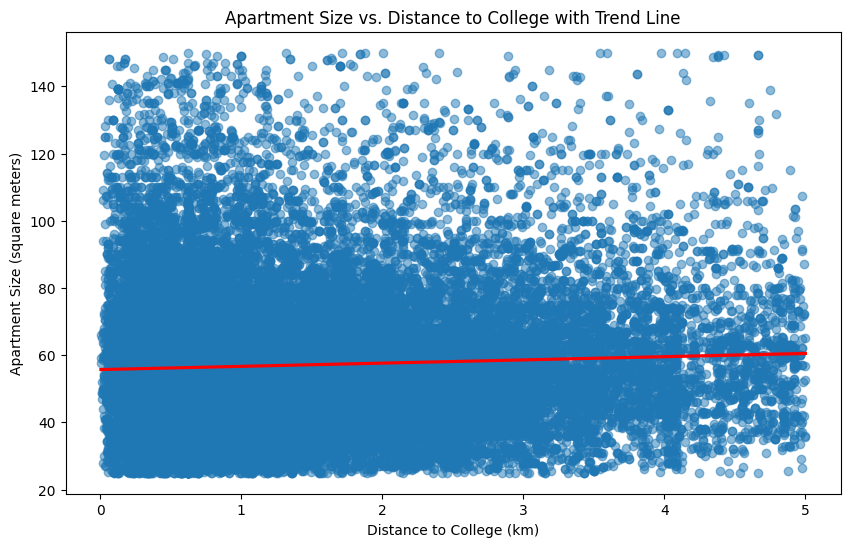

In [ ]:
# Scatter Plot with a trend line
plt.figure(figsize=(10, 6))
sns.regplot(data=combined_data, x='collegeDistance', y='squareMeters', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Apartment Size vs. Distance to College with Trend Line')
plt.xlabel('Distance to College (km)')
plt.ylabel('Apartment Size (square meters)')
plt.show()


56.523325727773404 57.99763201126497


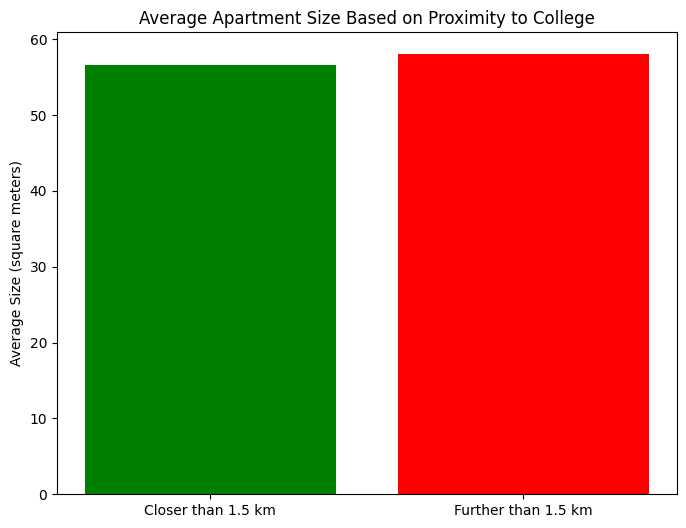

In [ ]:
mean_close = combined_data[combined_data['collegeDistance'] < 1.5]['squareMeters'].mean()
mean_far = combined_data[combined_data['collegeDistance'] >= 1.5]['squareMeters'].mean()
print(mean_close, mean_far)

categories = ['Closer than 1.5 km', 'Further than 1.5 km']
means = [mean_close, mean_far]

plt.figure(figsize=(8, 6))
plt.bar(categories, means, color=['green', 'red'])
plt.title('Average Apartment Size Based on Proximity to College')
plt.ylabel('Average Size (square meters)')
plt.show()

In [ ]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_data[features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, combined_data[target], test_size=0.3, random_state=1)

# Further split for validation set
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.7, random_state=1)


In [ ]:
# Standardize the data (fit on training data, transform on train, val and test sets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Fit PCA on the training data
pca = PCA(n_components=0.95)
pca.fit(X_train_scaled)

# Transform the training, validation, and test data
X_train_pca = pca.transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# -------------- Linear Regression ---------------
linear_model = LinearRegression()
linear_model.fit(X_train_pca, y_train)

# Predict on the val set
linear_predictions = linear_model.predict(X_val_pca)

# Evaluate the Linear Regression model
linear_mse = mean_squared_error(y_val, linear_predictions)
linear_r2 = r2_score(y_val, linear_predictions)

# ----------------Neural Network -----------------------
neural_network_model = MLPRegressor(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=1
)

neural_network_model.fit(X_train_pca, y_train)

# Predict on the validation set using Neural Network Regressor
neural_network_predictions = neural_network_model.predict(X_val_pca)

# Evaluate the Neural Network Regressor
neural_network_mse = mean_squared_error(y_val, neural_network_predictions)
neural_network_r2 = r2_score(y_val, neural_network_predictions)

# results
linear_mse, linear_r2, neural_network_mse, neural_network_r2

#----------- Support Vector Regressor ----------------
svr_model = SVR(kernel='rbf')

# Fit the model on the training data
svr_model.fit(X_train_pca, y_train)

# Predict on the validation set
y_val_pred_svr = svr_model.predict(X_val_pca)

# Evaluate the model
mse_val_svr = mean_squared_error(y_val, y_val_pred_svr)
r2_val_svr = r2_score(y_val, y_val_pred_svr)

print(f'Linear Regression MSE: {linear_mse}')
print(f'Linear Regression R²: {linear_r2}')
print(f'Neural Network MSE: {neural_network_mse}')
print(f'Neural Network R²: {neural_network_r2}')
print(f"SVR MSE: {mse_val_svr}")
print(f"SVR R²: {r2_val_svr}")

Linear Regression MSE: 403.8373533193589
Linear Regression R²: 0.007650448006953359
Neural Network MSE: 394.76757570336764
Neural Network R²: 0.02993761307458853
SVR MSE: 412.239828518162
SVR R²: -0.012996954791794302


In [ ]:
# ---------------- XGBoost Regressor --------------------
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=1)
xgb_model.fit(X_train_pca, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val_pca)

# Evaluate the model
mse_val_xgb = mean_squared_error(y_val, y_val_pred_xgb)
r2_val_xgb = r2_score(y_val, y_val_pred_xgb)

print(f"Validation MSE for XGBoost: {mse_val_xgb}")
print(f"Validation R² for XGBoost: {r2_val_xgb}")


Validation MSE for XGBoost: 395.61883546888
Validation R² for XGBoost: 0.027845812402876535


In [ ]:
# ------------------- RandomForest Regressor ----------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
rf_model.fit(X_train_pca, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_pca)

# Evaluate the model
mse_val_rf = mean_squared_error(y_val, y_val_pred_rf)
r2_val_rf = r2_score(y_val, y_val_pred_rf)

print(f"Validation MSE for RandomForest: {mse_val_rf}")
print(f"Validation R² for RandomForest: {r2_val_rf}")


Validation MSE for RandomForest: 330.00910715554426
Validation R² for RandomForest: 0.1890686016346499


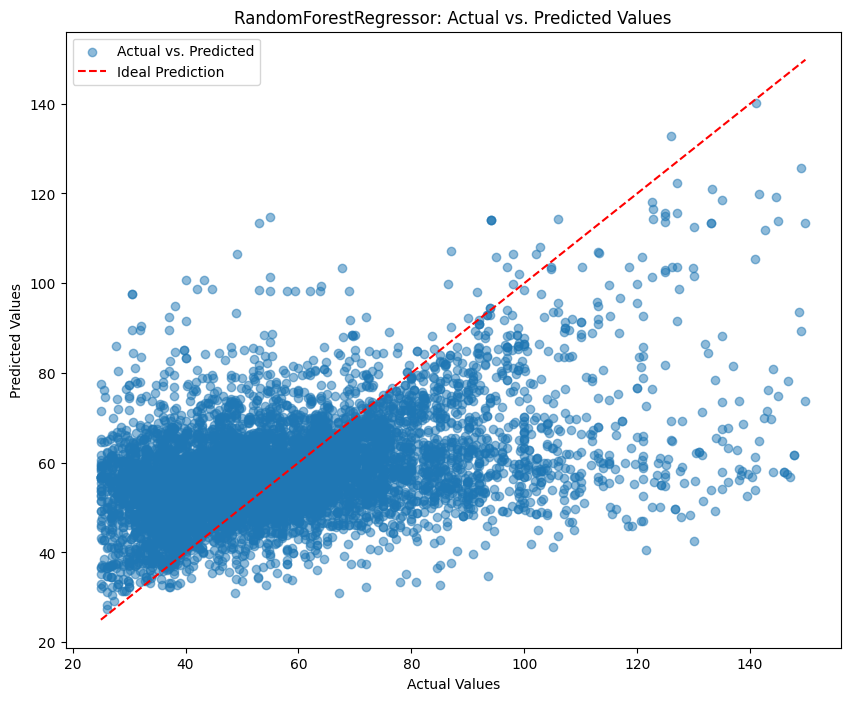

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(y_val, y_val_pred_rf, alpha=0.5, label='Actual vs. Predicted')

plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', label='Ideal Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RandomForestRegressor: Actual vs. Predicted Values')
plt.legend()
plt.show()

In [ ]:
# ------------------ Polynomial --------------------
degree = 3

# Create a pipeline that first transforms the data to polynomial features, then applies linear regression
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

poly_model.fit(X_train_pca, y_train)

y_pred_val_poly = poly_model.predict(X_val_pca)

poly_mse = mean_squared_error(y_val, y_pred_val_poly)
poly_r2 = r2_score(y_val, y_pred_val_poly)

print(f'Polynomial Regression (Degree {degree}) MSE: {poly_mse}')
print(f'Polynomial Regression (Degree {degree}) R2: {poly_r2}')



Polynomial Regression (Degree 3) MSE: 401.33152237163006
Polynomial Regression (Degree 3) R2: 0.013808026541751617


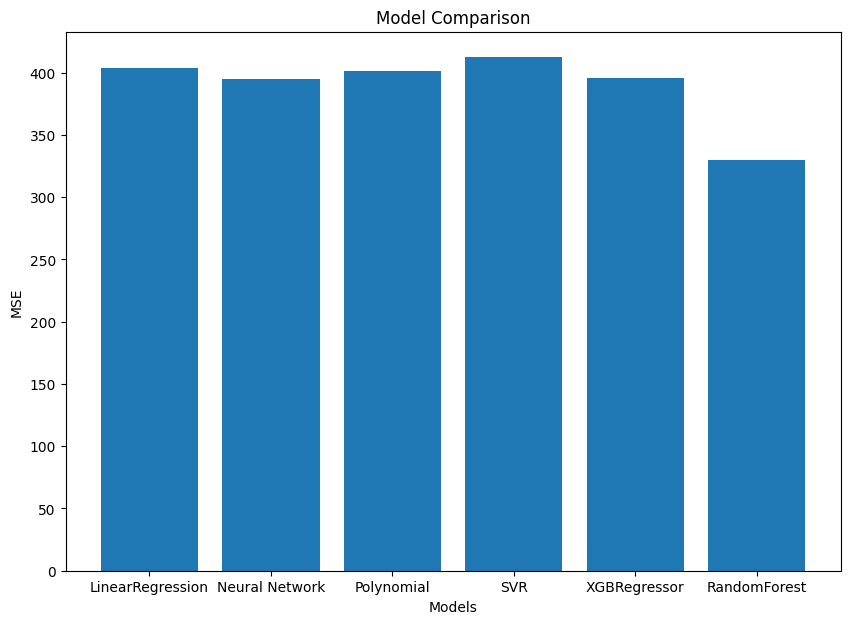

In [ ]:
metrics = [linear_mse, neural_network_mse, poly_mse, mse_val_svr, mse_val_xgb, mse_val_rf]
labels = ['LinearRegression', 'Neural Network', 'Polynomial', 'SVR', 'XGBRegressor', 'RandomForest']

plt.figure(figsize=(10, 7))
plt.bar(labels, metrics)
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Model Comparison')
plt.show()

In [ ]:
regression_scores = cross_val_score(linear_model, X_train_pca, y_train, cv=5, scoring='neg_root_mean_squared_error')
regression_scores = -regression_scores # positive rmse

mean_regression_score = np.mean(regression_scores)
print(f"Mean regression RMSE: {mean_regression_score}")


Mean regression RMSE: 20.35549218571493


In [ ]:
# Compare the results of 3-fold, 5-fold, and 10-fold cross-validation

for cv in [3, 5, 10]:
  cv_scores = cross_val_score(linear_model, X_train_pca, y_train, cv=cv, scoring='neg_root_mean_squared_error')
  cv_scores = -cv_scores
  mean_cv_score = np.mean(cv_scores)
  print(f"Mean RMSE for {cv}-fold cross-validation: {mean_cv_score}")


Mean RMSE for 3-fold cross-validation: 20.3580248208974
Mean RMSE for 5-fold cross-validation: 20.35549218571493
Mean RMSE for 10-fold cross-validation: 20.352099153362914


In [ ]:
regression_scores = cross_validate(linear_model, X_train_pca, y_train, cv=5, scoring={'r2': 'r2', 'mae': 'neg_mean_absolute_error'})
regression_scores['test_mae'] = -regression_scores['test_mae']

print("R2 scores:", regression_scores['test_r2'])
print("Mean absolute error scores:" ,regression_scores['test_mae'])

R2 scores: [0.00550281 0.0051078  0.00293235 0.00540629 0.0053472 ]
Mean absolute error scores: [15.26355618 15.57560352 15.42391743 15.15588154 15.53999631]


In [ ]:
# --------------- Grid Serach CV ------------------------
regressor = RandomForestRegressor()

param_grid = {
   'n_estimators': [100, 150, 200],
   'max_features': ['sqrt', 'log2', None],
   'max_depth': [3, 6, 9],
   'max_leaf_nodes': [3, 6, 9],
}

grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train_pca, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)

results = pd.DataFrame(grid_search.cv_results_)
print(results)

Best parameters: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 200}
Best estimator: RandomForestRegressor(max_depth=9, max_features=None, max_leaf_nodes=9,
                      n_estimators=200)
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.801856      0.028655         0.006687        0.000066   
1        1.243947      0.095565         0.012517        0.001708   
2        1.542881      0.022141         0.012950        0.001252   
3        0.917421      0.086727         0.011280        0.001796   
4        1.234301      0.012667         0.012349        0.000344   
..            ...           ...              ...             ...   
76       3.561844      0.197961         0.014125        0.001966   
77       4.671206      0.165590         0.018101        0.002024   
78       2.645472      0.137873         0.010578        0.001156   
79       3.890348      0.206603         0.014530        0.000374   
80       5.256338      0.2

In [ ]:
# ------------------------ Randomized Search CV ------------------------
param_dist = {
    'n_estimators': sp_randint(50, 200),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'max_features': [1.0, 'sqrt', 'log2'] # 1.0 to maintain current behavior
}

regressor = RandomForestRegressor()

random_search = RandomizedSearchCV(regressor, param_distributions=param_dist,
                                   n_iter=100, cv=5, scoring='neg_mean_squared_error',
                                   random_state=42, verbose=1)

random_search.fit(X_train_pca, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best model found: ", random_search.best_estimator_)

results = pd.DataFrame(random_search.cv_results_)
print(results)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'max_depth': 30, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 196}
Best model found:  RandomForestRegressor(max_depth=30, n_estimators=196)
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       11.410849      0.118289         0.075093        0.000854   
1        5.277027      0.191841         0.079842        0.005914   
2        1.774767      0.129867         0.028647        0.000832   
3        2.398814      0.173577         0.037855        0.000614   
4        2.113532      0.067902         0.023540        0.001709   
..            ...           ...              ...             ...   
95       3.925664      0.153347         0.040830        0.000783   
96       6.884358      0.270616         0.115453        0.005597   
97       5.417324      0.196979         0.102154        0.007451   
98       5.364456      0.240385         0.127604     

In [ ]:
# Retrain model with Optimal Parameters

best_params = random_search.best_params_
best_model = random_search.best_estimator_

optimized_rf = RandomForestRegressor(**best_params)
optimized_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=196)

In [ ]:
# --------------- final evaluation on the TEST set -------------------

y_test_pred = optimized_rf.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

(test_mse, test_r2)

(326.3203109626054, 0.2037502167265446)

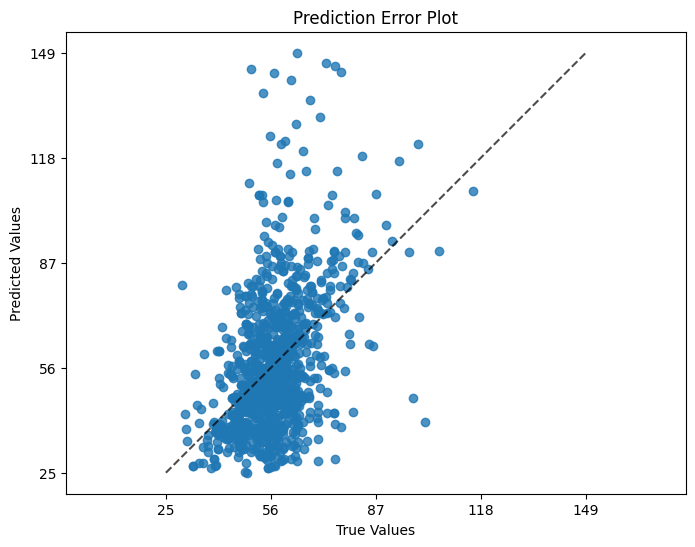

In [ ]:
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestRegressor

# regressor = RandomForestRegressor()

# regressor.fit(X_train_pca, y_train)

# y_pred = regressor.predict(X_train_pca)

#------------- Prediction error plot --------------------
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(figsize=(8, 6))
PredictionErrorDisplay.from_predictions(y_test, y_test_pred, ax=ax, kind="actual_vs_predicted")

ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
ax.set_title("Prediction Error Plot")

plt.show()
